In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow.compat.v1 as tfv1

import IPython
from IPython.display import display

import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import deque

import os
import datetime
import seaborn as sns

import random
import time

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

In [2]:
df = pd.read_csv("universe_dataset.csv", index_col="txn_date")
df.head()

,gross_amount,gross_cost,margin,tax_amount
txn_date,,,,
2020-05-19,0.830373,0.0,391.5,10.5
2020-06-19,0.817810,125.0,240.0,22.0
2020-06-26,0.635229,81.0,75.0,0.0
2020-07-16,0.000000,0.0,75.0,0.0
2020-07-17,0.946910,125.0,661.6,44.4


In [3]:
date = pd.to_datetime(df.index, format='%Y.%m.%d')

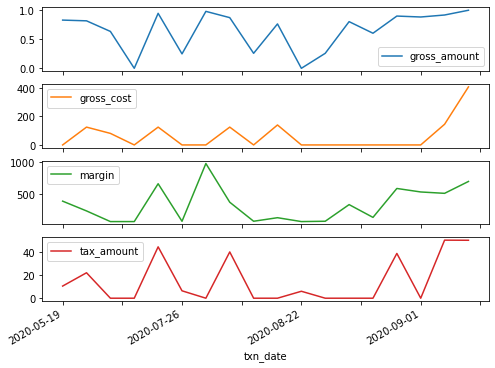

In [4]:
df.plot(subplots=True)
plt.show()

In [5]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gross_amount,18.0,0.651265,0.340558,0.0,0.344696,0.810791,0.895875,1.0
gross_cost,18.0,63.777778,104.738641,0.0,0.000000,0.000000,125.000000,407.0
margin,18.0,336.260000,273.593258,75.0,80.000000,289.000000,528.700000,975.0
tax_amount,18.0,14.906667,19.958931,0.0,0.000000,3.000000,34.540000,50.2


In [6]:
np.random.seed(314)
tf.random.set_seed(314)
tfv1.random.set_random_seed(314)
random.seed(314)

Preparing the Dataset
=====================
As a first step, we need to write a function that downloads the dataset from the Internet and preprocess it:

In [7]:
def shuffle_in_unison(a, b):
    # shuffle two arrays in the same way
    state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(state)
    np.random.shuffle(b)

def load_data(df, n_steps=5, scale=True, shuffle=True, lookup_step=1, split_by_date=True, test_size=0.2, feature_columns=list(df.columns)):
    if not isinstance(df, pd.DataFrame):
        raise TypeError("Data can only be a pd.DataFrame instance")
        
           
    # this will contain all the elements we want to return from this function
    result = {}
    
    result["df"] = df.copy()
    
    # make sure that the passed cols exist in the dataframe
    for col in feature_columns:
        assert col in df.columns, f"'{col}' does not exist in the dataframe."
        
    # add date to dataframe if not exist
    if "date" not in df.columns:
        df["date"] = df.index
        
    if scale:
        column_scaler = {}
        
        # Scale the data (price) from 0 - 1
        for column in feature_columns:
            if column == "date":
                pass
            
            scaler = preprocessing.MinMaxScaler()
            df[column] = scaler.fit_transform(np.expand_dims(df[column].values, axis=1))
            column_scaler[column] = scaler
            
        # add the MinMaxScaler instances to the result returned
        result["column_scaler"] = column_scaler
        
    # add the target column (label) by shifting by `look_back`
    df["future"] = df["gross_amount"].shift(-lookup_step)
    
    # last `lookup_step` columns contains NaN in future column
    # get them before droping NaNs
    last_sequence = np.array(df[feature_columns].tail(lookup_step), dtype=np.float32)
        
    # drop NaNs
    df.dropna(inplace=True)
    
    sequence_data = []
    sequences = deque(maxlen=n_steps)
    

    for entry, target in zip(df[feature_columns + ["date"]].values, df["future"].values):
        sequences.append(entry)
        
        if len(sequences) == n_steps:
            sequence_data.append([np.array(sequences), target])
            
    # get the last sequence by appending the last `n_step` sequence with `lookup_step` sequence
    # for instance, if n_steps=50 and lookup_step=10, last_sequence should be of 60 (that is 50+10) length
    # this last_sequence will be used to predict gross_amount revenue that are not available in the dataset
    
    last_sequence = list([s[: len(feature_columns)] for s in sequences]) + list(last_sequence)
    last_sequence = np.array(last_sequence).astype(np.float32)
    
    # add to result
    result["last_sequence"] = last_sequence
    
    # construct the X and y
    X, y = [], []
    
    for seq, target in sequence_data:
        X.append(seq)
        y.append(target)
        
    # Convert to numpy arrays
    X = np.array(X)
    y = np.array(y)   
    
    if split_by_date:
        # split the dataset into training & testing set by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(X))
        
        result["X_train"] = X[:train_samples]
        result["y_train"] = y[:train_samples]
        result["X_test"] = X[train_samples:]
        result["y_test"] = y[train_samples:]
        
        if shuffle:
            # shuffle the datasets for training (if shuffle parameter is set)
            shuffle_in_unison(result["X_train"], result["y_train"])
            shuffle_in_unison(result["X_test"], result["y_test"])
            
    else:    
        # split the dataset randomly
        result["X_train"], result["X_test"], result["y_train"], result["y_test"] = train_test_split(X, y, test_size=test_size, shuffle=shuffle)
    
    # get the list of test set dates
    dates = result["X_test"][:, -1, -1]
    
    # retrive test features from the original dataframe
    result["test_df"] = result["df"].loc[dates]
    
    # remove duplicates dates in the testing dataframe
    result["test_df"] = result["test_df"][~result["test_df"].index.duplicated(keep='first')]
      
    # remove dates from the training/testing sets & convert to float32
    result["X_train"] = result["X_train"][:, :, :len(feature_columns)].astype(np.float32)
    result["X_test"] = result["X_test"][:, :, :len(feature_columns)].astype(np.float32)
    
    return result

Model Creation
==============
Now that we have a proper function to load and prepare the dataset, we need another core function to build our model:

In [8]:
from tensorflow.keras.layers import Dense, Bidirectional, Dropout, LSTM

def create_model(sequence_length, n_features, units=256, cell=LSTM, n_layers=2, dropout=0.3, loss="mean_absolute_error", optimizer="rmsprop", bidirectional=False):
    model = tfv1.keras.Sequential()
    
    for i in range(n_layers):
        if i == 0:
            # first layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True), batch_input_shape=(None, sequence_length, n_features)))
                
            else:
                model.add(cell(units, return_sequences=True, batch_input_shape=(None, sequence_length, n_features)))
                
        elif i == n_layers - 1:
            # last layer
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=False)))
                
            else:
                model.add(cell(units, return_sequences=False))
                
        else:
            # hidden layers
            if bidirectional:
                model.add(Bidirectional(cell(units, return_sequences=True)))
                
            else:
                model.add(cell(units, return_sequences=True))
                
        # add dropout after each layer
        model.add(Dropout(dropout))
        
    model.add(Dense(1, activation="linear"))
    model.compile(loss=loss, metrics=["mean_absolute_error"], optimizer=optimizer)
    
    return model

Training the Model
==================
Now that we have all the core functions ready, let's train our model, but before we do that, let's initialize all our parameters 

In [9]:
# Window size or the sequence length
N_STEPS = 5

# Lookup step, 1 is the next day
LOOKUP_STEP = 1

# whether to scale feature columns & output price as well
SCALE = True
scale_str = f"sc-{int(SCALE)}"

# whether to shuffle the dataset
SHUFFLE = False
shuffle_str = f"sh-{int(SHUFFLE)}"

# whether to split the training/testing set by date
SPLIT_BY_DATE = False
split_by_date_str = f"sbd-{int(SPLIT_BY_DATE)}"

# test ratio size, 0.2 is 20%
TEST_SIZE = 0.3

# features to use
FEATURE_COLUMNS = list(df.columns)

# date now
date_now = time.strftime("%Y-%m-%d")

### model parameters
N_LAYERS = 2

# LSTM cell
CELL = tfv1.keras.layers.GRU

# 256 LSTM neurons
UNITS = 25 #256

# 40% dropout
DROPOUT = 0.3

# whether to use bidirectional RNNs
BIDIRECTIONAL = False

### TRAINING PARAMETERS
# mean absolute error loss
# LOSS = "mae"
# huber loss
LOSS = "huber_loss"

OPTIMIZER = "adam"
BATCH_SIZE = 2
EPOCHS = 20

ticker = "UNIVERS"
# model name to save, making it as unique as possible based on parameters
model_name = f"{date_now}_{ticker}-{shuffle_str}-{scale_str}-{split_by_date_str}-{LOSS}-{OPTIMIZER}-{CELL.__name__}-seq-{N_STEPS}-step-{LOOKUP_STEP}-layers-{N_LAYERS}-units-{UNITS}"

if BIDIRECTIONAL:
    model_name += "-b"
    
model_name

'2021-01-19_UNIVERS-sh-0-sc-1-sbd-0-huber_loss-adam-GRU-seq-5-step-1-layers-2-units-25'

In [10]:
# create these folders if they does not exist
if not os.path.isdir("results"):
    os.mkdir("results")
if not os.path.isdir("logs"):
    os.mkdir("logs")

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

# load the data
data = load_data(df, N_STEPS, scale=SCALE, split_by_date=SPLIT_BY_DATE, shuffle=SHUFFLE, lookup_step=LOOKUP_STEP, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)

# construct the model
model = create_model(N_STEPS, len(FEATURE_COLUMNS), loss=LOSS, units=UNITS, cell=CELL, n_layers=N_LAYERS, dropout=DROPOUT, optimizer=OPTIMIZER, bidirectional=BIDIRECTIONAL)
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, expand_nested=True)

# some tensorflow callbacks
checkpointer = ModelCheckpoint(os.path.join("results", model_name + ".h5"), save_weights_only=True, save_best_only=True, verbose=1)
tensorboard = TensorBoard(log_dir=os.path.join("logs", model_name))

In [12]:
data["X_train"].shape

(9, 5, 4)

In [13]:
# train the model and save the weights whenever we see 
# a new optimal model using ModelCheckpoint
history = model.fit(data["X_train"], data["y_train"], batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(data["X_test"], data["y_test"]),
                    callbacks=[checkpointer, tensorboard], verbose=1)

Epoch 1/20
5/5 [==============================] - ETA: 0s - loss: 0.2082 - mean_absolute_error: 0.5533
Epoch 00001: val_loss improved from inf to 0.38025, saving model to results/2021-01-19_UNIVERS-sh-0-sc-1-sbd-0-huber_loss-adam-GRU-seq-5-step-1-layers-2-units-25.h5
5/5 [==============================] - 2s 444ms/step - loss: 0.2082 - mean_absolute_error: 0.5533 - val_loss: 0.3802 - val_mean_absolute_error: 0.8709
Epoch 2/20
5/5 [==============================] - ETA: 0s - loss: 0.1741 - mean_absolute_error: 0.4885
Epoch 00002: val_loss improved from 0.38025 to 0.28443, saving model to results/2021-01-19_UNIVERS-sh-0-sc-1-sbd-0-huber_loss-adam-GRU-seq-5-step-1-layers-2-units-25.h5
5/5 [==============================] - 1s 103ms/step - loss: 0.1741 - mean_absolute_error: 0.4885 - val_loss: 0.2844 - val_mean_absolute_error: 0.7538
Epoch 3/20
5/5 [==============================] - ETA: 0s - loss: 0.1205 - mean_absolute_error: 0.4048
Epoch 00003: val_loss improved from 0.28443 to 0.20996,

In [14]:
%load_ext tensorboard
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 11524), started 1:02:55 ago. (Use '!kill 11524' to kill it.)

Testing the Model
=================
Now that we've trained our model, let's evaluate it and see how it's doing on the testing set, the below function takes a pandas Dataframe and plots the true and predicted prices in the same plot using matplotlib, we'll use it later:

In [15]:
def get_final_df(model, data):
    X_test = data["X_test"]
    y_test = data["y_test"]
    
    # perform prediction and get prices
    y_pred = model.predict(X_test)
    
    if SCALE:
        y_test = np.squeeze(data["column_scaler"]["gross_amount"].inverse_transform(np.expand_dims(y_test, axis=0)))
        y_pred = np.squeeze(data["column_scaler"]["gross_amount"].inverse_transform(y_pred))
        
    test_df = data["test_df"]
    
    # add predicted future prices to the dataframe
    test_df[f"gross_amount_{LOOKUP_STEP}"] = y_pred
    # add true future prices to the dataframe
    test_df[f"true_gross_amount_{LOOKUP_STEP}"] = y_test
    
    # sort the dataframe by date
    test_df.sort_index(inplace=True)
    
    return test_df

def plot_graph(test_df):
    """
    This function plots true gross_amount along with predicted gross_amount
    with blue and red colors respectively
    """
    plt.plot(test_df[f'true_gross_amount_{LOOKUP_STEP}'], c='b')
    plt.plot(test_df[f'gross_amount_{LOOKUP_STEP}'], c='r')
    plt.xlabel("Days")
    plt.ylabel("Amount")
    plt.legend(["Actual Amount", "Predicted Amount"])
    plt.show()
    
    
def predict(model, data):
    # retrieve the last sequence from data
    last_sequence = data["last_sequence"][-N_STEPS:]
    
    # expand dimension
    last_sequence = np.expand_dims(last_sequence, axis=0)
    
    # get the prediction (scaled from 0 to 1)
    prediction = model.predict(last_sequence)
    
    # get the price (by inverting the scaling)
    if SCALE:
        predicted_price = data["column_scaler"]["gross_amount"].inverse_transform(prediction)[0][0]
    else:
        predicted_price = prediction[0][0]
        
    return predicted_price
    
    
# load optimal model weights from results folder
model_path = os.path.join("results", model_name) + ".h5"
model.load_weights(model_path)

# evaluate the model
loss, mae = model.evaluate(data["X_test"], data["y_test"], verbose=0)
# calculate the mean absolute error (inverse scaling)
if SCALE:
    mean_absolute_error = data["column_scaler"]["gross_amount"].inverse_transform([[mae]])[0][0]
    
else:
    mean_absolute_error = mae
    
    
# get the final dataframe for the testing set
final_df = get_final_df(model, data)

# predict the future price
future_gross_amount = predict(model, data)

In [16]:
display(future_gross_amount)
final_df

0.7905788

,gross_amount,gross_cost,margin,tax_amount,gross_amount_1,true_gross_amount_1
txn_date,,,,,,
2020-08-30,0.603939,0.0,140.00,0.00,0.486360,0.899895
2020-08-31,0.899895,0.0,588.28,38.72,0.486837,0.883816
2020-09-01,0.883816,0.0,534.00,0.00,0.581646,0.918172
2020-09-02,0.918172,145.0,512.80,50.20,0.682682,1.000000


Future price after 1 days is 0.79$


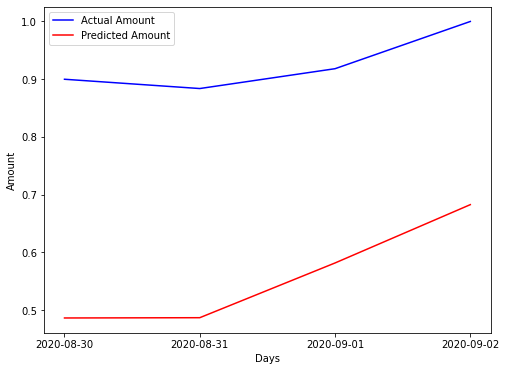

In [17]:
# printing metrics
print(f"Future price after {LOOKUP_STEP} days is {future_gross_amount:.2f}$")

# plot true/pred prices graph
plot_graph(final_df)